<a href="https://colab.research.google.com/github/sai-teja-ponugoti/Machine-Learning-Concepts/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing required moduels
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
# do not use disable_progress_bar function if you want to know 
# the progress of data preproessing steps 
tfds.disable_progress_bar()

# importing the cats_vs_dogs tensorflow inbuilt dataset and splitting the data 
# using load() function in ratios train data =0.2, validation=0.05 and test=0.05
(train_raw, validation_raw, test_raw), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:20%]', 'train[80%:85%]', 'train[90%:95%]'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
)

**Data preprocessing**

In [0]:
# print(raw_train)
# print(raw_validation)
# print(raw_test)
# print(metadata)

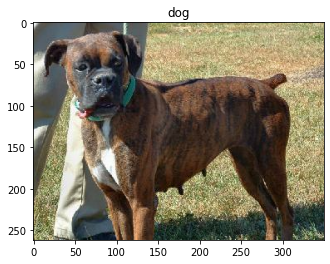

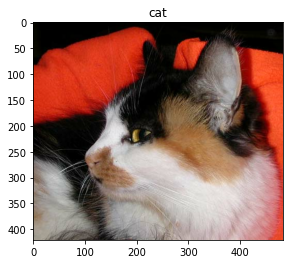

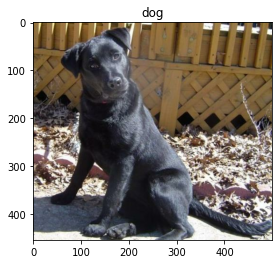

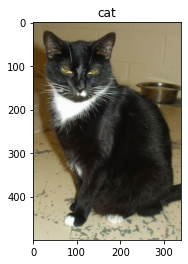

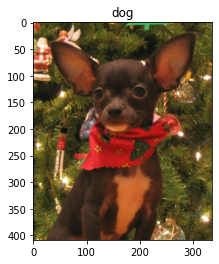

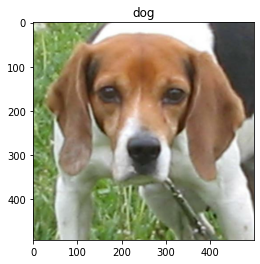

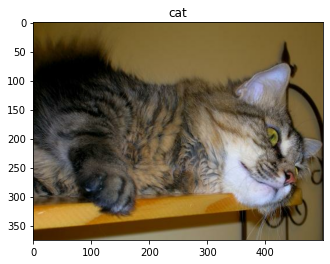

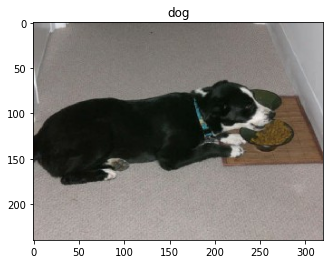

In [98]:
# getting label names
get_label_name = metadata.features['label'].int2str
# print(get_label_name)
for image, label in train_raw.take(8):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

**Format the Data**

In [0]:
# any image size can be selected
IMG_SIZE = 160 # All images will be resized to 224x224x3

def image_formatting(image, label):
    # converting pixel values to float type
    image = tf.cast(image, tf.float32)
    # normalising the data to be in range of -1 tp +1 255/2 = 127.5
    image = (image/127.5) - 1
    # resizing all images to a shape of 224x*224*3
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [0]:
#converting all images to same shape and formatting them for quicker training of the model
train = train_raw.map(image_formatting)
validation = validation_raw.map(image_formatting)
test = test_raw.map(image_formatting)

Apply this function to each item in the dataset using the map method:

In [101]:
# print(train_raw)
# print(validation_raw)
# print(test_raw)
print(metadata)
# train_raw

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [0]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [104]:
# checking the batch formation
for image_batch, label_batch in train_batches.take(1):
    print(image_batch)
    print(label_batch)
#    pass

# expected size (batch_size,224*224*3)
image_batch.shape


tf.Tensor(
[[[[-0.12107842 -0.38774508 -0.6779412 ]
   [-0.10588235 -0.372549   -0.6627451 ]
   [-0.11568627 -0.36176467 -0.6598039 ]
   ...
   [ 0.06782328 -0.2615885  -0.58021605]
   [ 0.15735298 -0.17205882 -0.47009802]
   [ 0.17234993 -0.17274815 -0.4629442 ]]

  [[-0.11360294 -0.3802696  -0.6704657 ]
   [-0.10600489 -0.37267154 -0.66286767]
   [-0.12120097 -0.36727938 -0.66531867]
   ...
   [ 0.07405796 -0.25535384 -0.5739813 ]
   [ 0.16374852 -0.16566329 -0.46370247]
   [ 0.16323534 -0.16434589 -0.464208  ]]

  [[-0.10323989 -0.36990654 -0.66010267]
   [-0.11372548 -0.38039213 -0.67058825]
   [-0.13085938 -0.37693778 -0.67497706]
   ...
   [ 0.0818628  -0.247549   -0.5661765 ]
   [ 0.15882358 -0.15147057 -0.4558823 ]
   [ 0.1541131  -0.1302696  -0.46020985]]

  ...

  [[ 0.11372554  0.15294123  0.10588241]
   [ 0.11372554  0.15294123  0.10588241]
   [ 0.11774668  0.15696236  0.10990354]
   ...
   [ 0.20519306 -0.1033318  -0.42892155]
   [ 0.18148749 -0.09460784 -0.40780482]
   [ 

TensorShape([128, 160, 160, 3])

In [105]:
# defining the input image size 
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the MobileNet V2
# Choosing include_top = False , so that we can define our own classification layer
# Choosing weight = None to select a non-pretrained model
original_model = tf.keras.applications.MobileNetV2(
                                        input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights=None,
                                        )

# Checking the model summary and number of tunable prameters
original_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [106]:
# lets observe what is the feature vector shape given by the model
# without the inbuilt classification layer
feature_batch = original_model(image_batch)
print(feature_batch.shape)

# Setting up that the model can be trained
original_model.trainable = True

(128, 5, 5, 1280)


In [107]:

# building a GlobalAveragePooling2D
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# building a Dense output layer
prediction_layer = tf.keras.layers.Dense(1,activation = "sigmoid")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Adding GlobalAveragePooling2D and Dense output layer to form a model
model_non_pretrained = tf.keras.Sequential([
  original_model,
  global_average_layer,
  prediction_layer
])


(128, 1280)
(128, 1)


In [0]:
base_learning_rate = 0.0001
model_non_pretrained.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics=['accuracy']
    )

In [109]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model_non_pretrained.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

 9/20 [============>.................] - ETA: 2s - loss: 0.7141 - accuracy: 0.4800WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


10/20 [==============>...............] - 2s 241ms/step - loss: 0.7148 - accuracy: 0.4815
initial loss: 0.71
initial accuracy: 0.48


In [110]:
epochs_number = 10
history_non_pretrained = model_non_pretrained.fit(
    train_batches,
    epochs=epochs_number ,verbose = 1,
    validation_data = validation_batches
    )

Epoch 1/10
37/37 [==============================] - 22s 584ms/step - loss: 0.6885 - accuracy: 0.5271 - val_loss: 0.7126 - val_accuracy: 0.4815
Epoch 2/10
37/37 [==============================] - 21s 579ms/step - loss: 0.6652 - accuracy: 0.6008 - val_loss: 0.7112 - val_accuracy: 0.4815
Epoch 3/10
37/37 [==============================] - 21s 578ms/step - loss: 0.6380 - accuracy: 0.6758 - val_loss: 0.7091 - val_accuracy: 0.4815
Epoch 4/10
37/37 [==============================] - 22s 583ms/step - loss: 0.6174 - accuracy: 0.7255 - val_loss: 0.7069 - val_accuracy: 0.4815
Epoch 5/10
37/37 [==============================] - 21s 579ms/step - loss: 0.6055 - accuracy: 0.7521 - val_loss: 0.7047 - val_accuracy: 0.4815
Epoch 6/10
37/37 [==============================] - 21s 579ms/step - loss: 0.5958 - accuracy: 0.7762 - val_loss: 0.7023 - val_accuracy: 0.4815
Epoch 7/10
37/37 [==============================] - 22s 583ms/step - loss: 0.5928 - accuracy: 0.7857 - val_loss: 0.6994 - val_accuracy: 0.4815

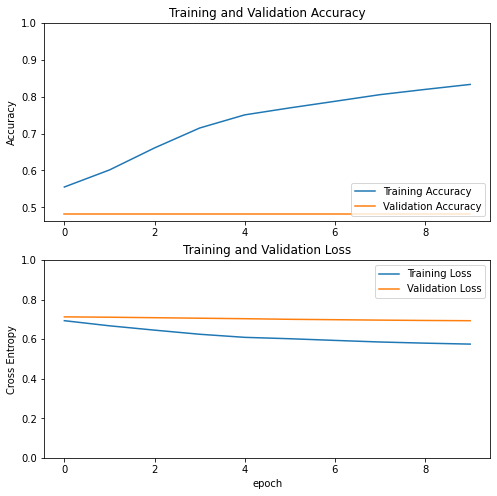

In [73]:
acc = history.history_non_pretrained['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [111]:
# Evaluating teh accuracy on test set batches
results = model_non_pretrained.evaluate(test_batches)
print('test loss, test acc:', results)

10/10 [==============================] - 2s 234ms/step - loss: 0.6991 - accuracy: 0.4953
test loss, test acc: [0.6991336941719055, 0.49527084827423096]


Create the base model from the pre-trained convnets.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [129]:
# Create the base model from the pre-trained model MobileNet V2
frozen_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
    )

# lets observe what is the feature vector shape given by the model
# without the inbuilt classification layer
feature_batch = frozen_model(image_batch)
print(feature_batch.shape)

# Freezing all the layers of the model
frozen_model.trainable = False

# Checking the number of trainable parametres Expected : 0
frozen_model.summary()

# Adding GlobalAveragePooling2D and Dense output layer to form a model
model_frozen_pretrained = tf.keras.Sequential([
  frozen_model,
  global_average_layer,
  prediction_layer
])

(128, 5, 5, 1280)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_____________________________________________________________

In [130]:
# Compiling the mode by including optimizer, loss function and metrics 
model_frozen_pretrained.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics=['accuracy']
    )

# Number of epochs
epochs_number = 10
# Fitting the model with train batches
history_freeze = model_frozen_pretrained.fit(
    train_batches,
    epochs=epochs_number ,verbose = 1,
    validation_data = validation_batches
    )

# Evaluating the accuracy on test set batches
results = model_frozen_pretrained.evaluate(test_batches)
print('test loss, test acc:', results)

 9/20 [============>.................] - ETA: 2s - loss: 0.5235 - accuracy: 0.9635WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


10/20 [==============>...............] - 2s 231ms/step - loss: 0.5239 - accuracy: 0.9639
initial loss: 0.52
initial accuracy: 0.96


**Fine tuning**

In [123]:
# Create the base model from the pre-trained model MobileNet V2
unfrozen_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
    )

# lets observe what is the feature vector shape given by the model
# without the inbuilt classification layer
feature_batch = unfrozen_model(image_batch)
print(feature_batch.shape)

# Freezing all the layers of the model below 100th layer
freeze_till_layer = 100

# Freeze all the layers before the `ffreeze_till_layer` layer
for layer in unfrozen_model.layers[:freeze_till_layer]:
  layer.trainable =  False

# Adding GlobalAveragePooling2D and Dense output layer to form a model
model_unfrozen_pretrained = tf.keras.Sequential([
  unfrozen_model,
  global_average_layer,
  prediction_layer
])

# Checking the number of trainable parametres Expected : 0
unfrozen_model.summary()

(128, 5, 5, 1280)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_____________________________________________________________

In [128]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model_unfrozen_pretrained .evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

 9/20 [============>.................] - ETA: 2s - loss: 0.5235 - accuracy: 0.9635WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


10/20 [==============>...............] - 2s 226ms/step - loss: 0.5239 - accuracy: 0.9639
initial loss: 0.52
initial accuracy: 0.96


In [122]:
# Compiling the mode by including optimizer, loss function and metrics 
model_unfrozen_pretrained.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics=['accuracy']
    )

# Number of epochs
epochs_number = 10
# Fitting the model with train batches
history_unfreeze = model_unfrozen_pretrained.fit(
    train_batches,
    epochs=epochs_number ,verbose = 1,
    validation_data = validation_batches
    )

# Evaluating the accuracy on test set batches
results = model_unfrozen_pretrained.evaluate(test_batches)
print('test loss, test acc:', results)

Epoch 1/10
37/37 [==============================] - 14s 386ms/step - loss: 0.5253 - accuracy: 0.9663 - val_loss: 0.5137 - val_accuracy: 0.9742
Epoch 2/10
37/37 [==============================] - 13s 363ms/step - loss: 0.5085 - accuracy: 0.9888 - val_loss: 0.5053 - val_accuracy: 0.9845
Epoch 3/10
37/37 [==============================] - 13s 360ms/step - loss: 0.5051 - accuracy: 0.9951 - val_loss: 0.5087 - val_accuracy: 0.9802
Epoch 4/10
37/37 [==============================] - 13s 359ms/step - loss: 0.5035 - accuracy: 0.9979 - val_loss: 0.5063 - val_accuracy: 0.9828
Epoch 5/10
37/37 [==============================] - 13s 362ms/step - loss: 0.5030 - accuracy: 0.9991 - val_loss: 0.5125 - val_accuracy: 0.9733
Epoch 6/10
37/37 [==============================] - 13s 358ms/step - loss: 0.5031 - accuracy: 0.9989 - val_loss: 0.5083 - val_accuracy: 0.9785
Epoch 7/10
37/37 [==============================] - 13s 360ms/step - loss: 0.5028 - accuracy: 0.9991 - val_loss: 0.5085 - val_accuracy: 0.9785

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))




Number of layers in the base model:  155


In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 55s 95ms/step - loss: 0.1187 - accuracy: 0.9562 - val_loss: 0.0799 - val_accuracy: 0.9781
Epoch 11/20
582/582 [==============================] - 54s 93ms/step - loss: 0.0636 - accuracy: 0.9749 - val_loss: 0.0551 - val_accuracy: 0.9828
Epoch 12/20
582/582 [==============================] - 56s 97ms/step - loss: 0.0494 - accuracy: 0.9818 - val_loss: 0.0493 - val_accuracy: 0.9828
Epoch 13/20
582/582 [==============================] - 54s 93ms/step - loss: 0.0386 - accuracy: 0.9843 - val_loss: 0.0496 - val_accuracy: 0.9837
Epoch 14/20
582/582 [==============================] - 55s 94ms/step - loss: 0.0298 - accuracy: 0.9877 - val_loss: 0.0486 - val_accuracy: 0.9828
Epoch 15/20
582/582 [==============================] - 54s 93ms/step - loss: 0.0243 - accuracy: 0.9914 - val_loss: 0.0504 - val_accuracy: 0.9828
Epoch 16/20
582/582 [==============================] - 55s 94ms/step - loss: 0.0190 - accuracy: 0.9927 - val_loss: 0.0522 - val_ac